<h1>Math</h1>

In this notebook of the series, we are going to extend our understanding of temporal difference methods 

In particular we know that what we've covered so far is called TD(0) and that there is a more general form called TD($\lambda$)

---

<h3>N-Step Methods & TD($\lambda$)</h3>

This notebook is all about how to extend to TD(0) so that we can get TD($\lambda$)

As we'll see TD($\lambda$) gives us a tradeoff between one step learning methods like TD(0) and calculating the full return like Monte Carlo

---

<h3>N-Step Methods</h3>

The first thing we need to learn about when discussing TD($\lambda$) is the $N$-Step method which is what this section is about 

The $N$-Step method works as follows

We know so far that the value function can be described recursively (Bellman's equation)

$$\large V(s) = \sum_a \pi( a\vert s) \sum_{s',r} p(s',r, \vert s,a) \{r+ \gamma V(s')\}$$

We also know that we can estimate $V$ by averaging the returns for many different episodes

$$\large V(s) \approx \frac{1}{N} \sum^N_{i=1} G_{i,s}$$

---

And we also know from $TD(0)$ that we can estimate $G$ itself by using our current estimate of $V$ 

$$\large G_s \approx r + \gamma V(s')$$

It's worth asking what is the most accurate thing in this estimate of $G$?

Well that would have to be the reward $r$ because it's an actual sample we got from our experiment

---

So it's plausible then that if we use more $r$s and less of $V$, the our estimate of $G$ becomes more accurate 

For example instead of taking the first reward and then using $V$ to estimate the rest 

$$\large G(t) \approx R(t+1) + \gamma V(s(t+1))$$

We can take the first reward and the reward after that and then use the next $V$ to estimate the rest

$$\large G(t) \approx R(t+1) + \gamma R(t+2) + \gamma^2 V(s(t+2))$$


Remember that Monte Carlo is just the extreme of this where we don't use $V$ at all

$$\large G(t) = R(t+1) + \gamma R(t+2) + \ldots + \gamma^{T-1} R(t+T)$$

---

Note that we can superscript $G$ to tell us how many $r$s we're using

$\large G^{(1)}(t) = R(t+1) + \gamma V(s(t+1))$

$\large G^{(2)}(t) = R(t+1) + \gamma R(t+2) + \gamma^2 V(s(t+2))$

$\ldots$

$\large G^{(T)}(t) = R(t+1) + \gamma R(t+2) + \ldots + \gamma^{(T-1)}R(t+T)$

note : assume episode end at time $t+T$

---

So we see how this gives us sort of a discrete transition from TD(0) to Monte Carlo 

Since Monte Carlo learning means that the agent can only be updated after the episode is over and TD(0) means that the agent can be updated after one step, then using $n$ steps of the actual rewards means we'll have to wait $n$ steps before our agent can be updated so that we can form the target using the actual rewards we got

In general if we want to use $n$ steps of $R$, we would create the target as follows

$$\large G^{(n)}(t) = R(t+1) + \gamma R(t+2) + \ldots + \gamma^{n-1}R(t+n) + \gamma^n V(s(t+n))$$

---

For updating $V$, if we're doing the prediction problem the update equation doesn't change

The only change is to $G$ itself

The only thing we have to do is wait $N$ steps before we can update $V$ for the state we are in now


The same thing of course applies to both tabular methods and function approximation methods

$$\large \text{Tabular : } V(s(t)) = V(s(t)) + \alpha \{G^{(n)}(t) - V(s(t))\}$$

$$\large \text{Function Approx : } \theta = \theta + \alpha \{G^{(n)}(t) - V(s(t))\} \frac{\partial V(s(t))}{\partial \theta}$$

---

<h3>Control</h3>

This of course can be extended to the control problem as well where we use $Q$ Instead of $V$

If we're doing $\text{SARSA}$ the update will be in terms of the chosen action and the chosen action will always be greedy or epsilon-greedy with respect to $Q$

$$\large G^{(n)}(t) = R(t+1) + \gamma R(t+2) + \ldots + \gamma^{n-1}R(t+n) + \gamma^n Q(s_{t+n},a_{t+n})$$

$$\large \theta = \theta + \alpha \left( G^{(n)}(t) - Q(s_t,a_t)\right) \frac{\partial Q(s_t,a_T)}{\partial \theta}$$

<h1>code</h1>

In [10]:
# we'll implelment the N-step method for mountain car
# we're going to make use of the Q-learning script for mountain car 
# that we already wrote in the previous notebook
# so that we can focus on the N-step part

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from matplotlib.cm import coolwarm # used in cost-to-go

In [2]:
env = gym.make('MountainCar-v0')

In [3]:
class FT: # Feature Transformer
    def __init__(self,env,n_samples = 10000,D=500,scales=[5,2,1,0.5]):
        # gather samples
        samples = []
        for _ in range(n_samples):
            samples.append(env.observation_space.sample())
        samples = np.array(samples)
        self.scaler = StandardScaler()
        samples = self.scaler.fit_transform(samples)
        
        samplers = []
        
        if type(D) != list:
            D = [D]*len(scales)
        
        for i in range(len(scales)):
            sampler = RBFSampler(gamma=scales[i],n_components=D[i])
            name = 'rbf' + str(i)
            samplers.append((name,sampler))

        # create our feature union
        self.FU = FeatureUnion(samplers)
        self.FU.fit(samples)
        self.D = sum(D)
        
            
    def transform(self,x):
        x = self.scaler.transform([x])
        x = self.FU.transform(x)
        return x

In [4]:
# next we define our SGDRegressor
class LinearModel:
    def __init__(self,D,learning_rate=1e-2):
        # recall one model per action
        # so its just D
        self.W = np.random.randn(D)/np.sqrt(D)
        self.lr = learning_rate
        
    def sgd(self,x,t):
        y = x@self.W
        delta = t-y
        self.W += self.lr*(delta@x)
        
    def predict(self,x):
        return x@self.W

In [5]:
class QANLM: # Q learning + Approximation + Linear Model
    def __init__(self,env,gamma=0.99,learning_rate=1e-2):
        self.gamma = gamma
        self.featuriser = FT(env)
        # recall we'll have a seperate model for each action
        A = env.action_space.n
        # linear models
        D = self.featuriser.D
        self.LMs = [LinearModel(D,learning_rate) for a in range(A)]
        x0 = self.featuriser.transform(env.reset())
        for lm in self.LMs:
            # so we are still using optimistic initial values
            lm.sgd(x0,0)
        self.env = env
    
    def epsilon_greedy(self,best_action,eps=0.1):
        if np.random.random() < eps:
            return np.random.choice(self.env.action_space.n)
        else:
            return best_action
        
    def get(self,s,get=None):
        x = self.featuriser.transform(s)
        Q = [lm.predict(x)[0] for lm in self.LMs]
        best_action = np.argmax(Q)
        max_Q = np.max(Q)        
        if get == 'value':
            return max_Q
        if get == 'action':
            return best_action
        
        return max_Q,best_action
    
    def play_episode(self,training = True,render = False):
        X = []
        A = []
        R = []
        env = self.env
        s = env.reset()
        X.append(s)
        done = False
        episode_reward = 0
        # gamma^0, gamma^1, gamma^2, ...., gamma^n
        gammas = self.gamma**np.arange(self.N+1)
        while not done:
            if render:
                env.render()
            a = self.get(s,get='action')
            if training == True:
                a = self.epsilon_greedy(a,self.eps)
                
            s_prime, r, done, _ = env.step(a)
            episode_reward += r
            
            X.append(s_prime)
            R.append(r)
            A.append(a)
            
            if training == True and len(R) == self.N:
                rewards = R + [self.get(X[-1],get='value')]
                G = gammas@rewards
                self.LMs[A[0]].sgd(self.featuriser.transform(X[0]),G)
                A.pop(0)
                X.pop(0)
                R.pop(0)
                
                
            s = s_prime
        if render:
            env.close()
            
        # now we continue updating
        # till we empty our arrays
        # we need to check whether or not we reached the terminal state
        # since after 200 steps, gym terminates the episode regardless of whether we finished or not
        # the documentation says that this happens when the position reaches 0.5
        if training:
            if s_prime[0] >= 0.5: # then we reached terminal state
                # if so then all subsequent rewards (from X[-1]) can be considered 0s
                # thus we do not use our epected sum of future rewards
                while len(R) != 0:
                    G = gammas[:len(R)]@R
                    self.LMs[A[0]].sgd(self.featuriser.transform(X[0]),G)
                    X.pop(0)
                    A.pop(0)
                    R.pop(0)
            else:
                # if we haven't hit the goal
                # then we need to make the assumption that we wouldn't have hot the goal in the next N steps
                # so we set any subsequent reward to -1
                # but we set the sum of future rewards at last step to 0
                while len(R) != 0:
                    rewards = R + [-1]*(self.N-len(R)) + [0]
                    G = gammas@rewards
                    self.LMs[A[0]].sgd(self.featuriser.transform(X[0]),G) 
                    X.pop(0)
                    A.pop(0)
                    R.pop(0)
        
        
        return episode_reward
      
    # the return of each episode are going to vary a lot
    # so it will be hard to see
    # we're interested in averaging the returns over 100 episodes
    # because the OpenAI documnetation says our agent is judged by how much it does over 100 episdoes
    def plot_running_avg(self,rewards):
        rewards = np.array(rewards)
        T = len(rewards)
        running_avg = np.zeros(T)
        for t in range(T):
            running_avg[t] = rewards[max(0,t-100):t+1].mean()
        plt.plot(running_avg)
        plt.title('running average')
        plt.show()
        
    def plot_cost_to_go(self, num_tiles=20):
        env = self.env
        x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
        y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
        X, Y = np.meshgrid(x, y)

        Z = np.zeros((num_tiles,num_tiles))
        for i in range(num_tiles):
            for j in range(num_tiles):
                s = (X[i,j],Y[i,j])
                x = self.featuriser.transform(s)
                Q_s =  [lm.predict(x)[0] for lm in self.LMs]
                Z[i][j] = -np.max(Q_s) # - V(s)

        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z,
            rstride=1, cstride=1, cmap=coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Position')
        ax.set_ylabel('Velocity')
        ax.set_zlabel('Cost-To-Go == -V(s)')
        ax.set_title("Cost-To-Go Function")
        fig.colorbar(surf)
        plt.show()
    
    def train(self,episodes = 300,N=5):
        rewards = []
        self.N = N
        for episode in range(episodes):
            # decaying epsilon
            self.eps = 0.1*(0.97**episode)
            reward = self.play_episode()
            rewards.append(reward)
            if (episode+1)%10 == 0:
                print('Episode: ',episode+1,'/',episodes,' reward = ',reward)
        plt.plot(rewards)
        plt.title('rewards per epoch')
        plt.show()
        self.plot_running_avg(rewards)
        self.plot_cost_to_go()
    
    def test(self,episodes=100):
        rewards = []
        for i in range(episodes):
            r = self.play_episode(training=False)
            rewards.append(r)
        print('Average test reward: ',np.mean(rewards))
    

In [6]:
model = QANLM(env)

Episode:  10 / 300  reward =  -200.0
Episode:  20 / 300  reward =  -153.0
Episode:  30 / 300  reward =  -172.0
Episode:  40 / 300  reward =  -105.0
Episode:  50 / 300  reward =  -143.0
Episode:  60 / 300  reward =  -200.0
Episode:  70 / 300  reward =  -129.0
Episode:  80 / 300  reward =  -135.0
Episode:  90 / 300  reward =  -92.0
Episode:  100 / 300  reward =  -160.0
Episode:  110 / 300  reward =  -167.0
Episode:  120 / 300  reward =  -142.0
Episode:  130 / 300  reward =  -140.0
Episode:  140 / 300  reward =  -84.0
Episode:  150 / 300  reward =  -84.0
Episode:  160 / 300  reward =  -168.0
Episode:  170 / 300  reward =  -136.0
Episode:  180 / 300  reward =  -141.0
Episode:  190 / 300  reward =  -136.0
Episode:  200 / 300  reward =  -138.0
Episode:  210 / 300  reward =  -166.0
Episode:  220 / 300  reward =  -145.0
Episode:  230 / 300  reward =  -136.0
Episode:  240 / 300  reward =  -84.0
Episode:  250 / 300  reward =  -143.0
Episode:  260 / 300  reward =  -137.0
Episode:  270 / 300  rewa

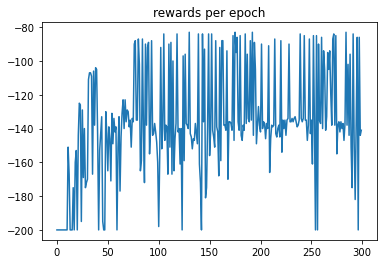

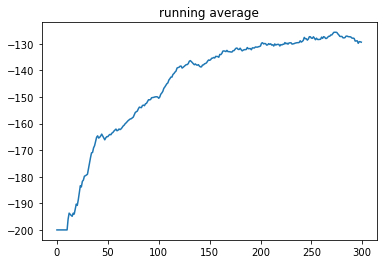

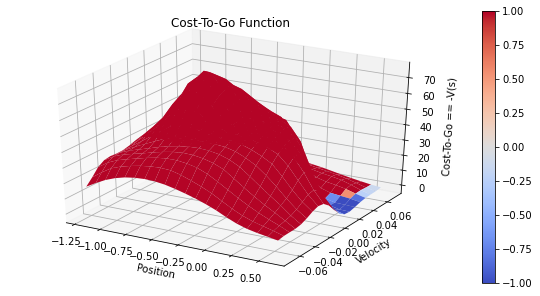

In [7]:
model.train()

In [8]:
model.test()

Average test reward:  -131.78


In [11]:
# see agent playing an episode
model.play_episode(training=False,render=True)

-137.0

<h1>Math</h1>

In this section we are going to discuss $\text{TD}(\lambda)$ as a generalization of the $N$-step method

Lambda($\lambda$) is a parameter that is associated with a vector called the eligibility trace which we'll be learning about in this section

---

<h3>$\text{TD}(\lambda)$</h3>

We may have noticed that the code for the $N$-step method was pretty complicated

In particular it's not so straightforward to keep track of the last $N$ rewards all the time

$\lambda$ allows us to use a more elegant method of choosing a tradeoff between $\text{TD}(0)$ and Monte-Carlo

In particular we won't have to keep track of the last $N$ steps and we'll be able to make updates without having to wait $N$ steps and instead just wait one step like in $\text{TD}(0)$ 

We'll see that $\lambda = 1$ corresponds to Monte-Carlo, $\lambda = 0$ corresponds to $\text{TD}(0)$ and any $\lambda$ in between is a tradeoff between the two

---

<h3>N-Step Method</h3>

So first let's further generalize the $N$ step method

Remember that we can define different $G$'s depending on how many $r$'s they depend on

$\large G^{(1)}(t) = R(t+1) + \gamma V(s(t+1)) \\ \large G^{(2)}(t) = R(t+1) + \gamma R(t+2) + \gamma^2 V(s(t+2)) \\ \large \ldots \\ \large G^{(n)}(t) = R(t+1) + \gamma R(t+2) + \ldots + \gamma^{n-1}R(t+n)$

A strange idea might be to form a return that is a combination of these G's

For example $$\large \frac{1}{2} G^{(1)}(t) + \frac{1}{2} G^{(2)}(t)$$

---

<h3>$\text{TD}(\lambda)$</h3>

Now to take that strangeness to the next level

Consider that we can sum up any number of $G$'s even an infinite amount of $G$'s

The only requirement is that the weightings for each $G$ have to sum to $1$, since the final $G$ must be on the same scale as the original $G$'s

$$\large \lambda_1 G^{(1)}(t) + \lambda_2 G^{(2)}(t) + \ldots + \lambda_n G^{(n)}(t), \ \sum^n_{i=1} \lambda_i = 1 $$

---

For the $\text{TD}(\lambda)$ method, the $\lambda$'s are given very specific values

In particular they decrease geometrically

$$\large \lambda^0 G^{(1)}(t) + \lambda^1 G^{(2)}(t) + \ldots + \lambda^{n-1}G^{(n)}(t)$$

And now if we notice these don't sum to $1$ since the first weight is already $1$

So they would need to be normalized

In particular we are interested in normalizing this for the case where $n$ is infinity 

---

From calculus, we know that the sum of these lambdas is 

$$\large \frac{1}{1-\lambda} = \sum_{i=0}^{\infty} \lambda^i$$

And so we should scale the sum of returns by $(1-\lambda)$

$$\large G_\lambda(t) = (1-\lambda) \sum^\infty_{n=1} \lambda^{n-1} G^{(n)}(t)$$

We call this the $\lambda$-return

---

Once we have our $\lambda$-return we can assume our episode is going to end at some point

Let's call that timestep $T$ 

Because we're counting from $n=1$ to infinity, when $n$ reaches $T-t$, the $N$ step return is really just the full sampled return $G(t)$


So we can manipulate the $\lambda$ return to separate the shorter $n$ step returns and the full sample returns

$$\large G_\lambda = (1- \lambda) \sum^{T-t-1}_{n=1} \lambda^{n-1} G^{(n)}(t) + (1-\lambda) \sum^\infty_{n=T-t} \lambda^{n-1} G(t)$$


We can manipulate the second term until we're left only with the part that depends on $n$ inside the sum

Now the next step is if you manipulate some of the identities related to series, we can solve for the second sum in closed form

$$\large \sum^\infty_{n=0} \lambda^n = \frac{1}{1-\lambda}, \sum^N_{n=0} \lambda^n = \frac{1-\lambda^{N+1}}{1-\lambda} \rightarrow \sum^\infty_{n=N+1} \lambda^n = \frac{\lambda^{N+1}}{1-\lambda}$$

$$\large G_\lambda(t) = (1-\lambda) \sum^{T-t-1}_{n=1} \lambda^{n-1} G^{(n)}(t) + (1-\lambda) G(t) \lambda^{-1} \frac{\lambda^{T-\tau}}{1-\lambda}$$

$$\large G_\lambda(t) = (1-\lambda) \sum^{T-t-1}_{n=1} \lambda^{n-1} G^{(n)}(t) + \lambda^{T-t-1} G(t)$$

So now we have an expression for the $\lambda$ return in terms of all the $N$ step returns that go up to the end of an episode and then the full return

---

What we should notice about this equation is that when $\lambda$ is zero we get the One-Step return since $0^0$ is $1$, this is $TD(0)$ 

When $\lambda$ is $1$, the first term is just $0$ and so we get the full return which is the Monte Carlo method

Any $\lambda$ in between will give us a combination of all the $n$-step returns with a geometrically decreasing weight

---

At this point the obvious question is, this seems worse than both Monte-Carlo and the $n$-step method in terms of computational effort 

With Monte-Carlo, all we need to do is compute the returns for the episode 

With the $n$-step method we have to compute the $n$-step return for every timestep 

But now we have to compute the Monte-Carlo return and all the $n$-step returns from $n=1$ all the way to the length of the episode

This sounds like a lot more work for what is not clearly a benefit

---

Now the next step requires some mathematical wizardry which is definitely outside the scope of this notebook, so no proof will be given

However this method has been around for some time so we should have no problem searching for papers that discuss it

This algorithm we're about to look at is in fact only an approximation to using the true $\lambda$ return that we just talked about

We of course don't actually want to use the true $\lambda$ return in any practical scenario because that would mean calculating all the different $n$-step returns and the full return

---

<h3>TD(0)</h3>

First let's recall what our parameter updates look like when we're doing TD$(0)$

We have 

$\qquad \text{target}: R_{t+1} + \gamma V(s_{t+1}) \\ \qquad \text{prediction}: V(s_t) \\ \qquad \text{difference} : \delta_t = R_{t+1} + \gamma V(s_{t+1}) - V(s_t)$

This Delta is called the $\text{TD(error)}$

This helps us tighten up the notation a little bit but this is still just plain gradient descent

$$\delta_{t+1} = \delta_t + \alpha \delta_t \nabla_\theta V(s_t)$$

---

<h3>Eligigbility Traces</h3>

To implement $TD(\lambda)$, we need to introduce the idea of the eligibility trace 

The eligibility trace is a vector the same size as our parameter vector $\theta$

$$\large \theta_t \in \mathfrak{R}^D, e_t \in \mathfrak{R}^D$$

Essentially it keeps track of our old gradients much like momentum in deep learning

We define the first eligibility trace as $0$ and then every subsequent eligibility vector will be the current gradient plus a fraction of the old eligibility vector

This fraction is just $\gamma \times \lambda$

$$\large e_0 = 0, e_t = \nabla_\theta V(s_t) + \gamma \lambda e_{t-1}$$

Basically $\lambda$ just tells us how much of the past we want to take into account

note : This is kind of what we showed earlier,  $\lambda = 1 \rightarrow \text{MC}, \lambda = 0 \rightarrow \text{TD}(0)$

---

We can then redefine the parameter update step to use the eligibility vector rather than just the gradient

$$\large \theta_{t+1} = \theta_t + \alpha \delta_t e_t$$

---

<h3>Connection to deep learning </h3>

Recall that momentum in deep learning works very similarly

$\large v_0 = 0, v_t = \nabla_\theta J + \mu v_{t-1} \\ \large \theta_{t+1} = \theta_t - \alpha v_t$


We keep a velocity vector which is the sum of the most recent gradient and part of the old velocity

Then we update $\theta$ to go in this direction like how our $\theta$ goes in the direction of the eligibility vector

---

<h3>Final Thoughts</h3>

Notice how because the update for $\theta$ now only depends on the next state, we can do our updates at the next step rather than waiting $n$ steps like in the $n$-step method 

But also remember that this is just an approximation to using the true $\lambda$ return

One distinction that is made sometimes because the $n$-step method and true $\lambda$-return require looking ahead to later states we call this the forward view whereas TD($\lambda$) we update our current state state on past errors so we call this the backward view

<h1>code</h1>

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from matplotlib.cm import coolwarm # used in cost-to-go

In [2]:
env = gym.make('MountainCar-v0')

In [3]:
class FT: # Feature Transformer
    def __init__(self,env,n_samples = 10000,D=500,scales=[5,2,1,0.5]):
        # gather samples
        samples = []
        for _ in range(n_samples):
            samples.append(env.observation_space.sample())
        samples = np.array(samples)
        self.scaler = StandardScaler()
        samples = self.scaler.fit_transform(samples)
        
        samplers = []
        
        if type(D) != list:
            D = [D]*len(scales)
        
        for i in range(len(scales)):
            sampler = RBFSampler(gamma=scales[i],n_components=D[i])
            name = 'rbf' + str(i)
            samplers.append((name,sampler))

        # create our feature union
        self.FU = FeatureUnion(samplers)
        self.FU.fit(samples)
        self.D = sum(D)
        
            
    def transform(self,x):
        x = self.scaler.transform([x])
        x = self.FU.transform(x)
        return x

In [59]:
# next we define our SGDRegressor
class LinearModel:
    def __init__(self,D,learning_rate=1e-2):
        # recall one model per action
        # so its just D
        self.W = np.random.randn(D)/np.sqrt(D)
        self.lr = learning_rate
        
    # modify this to also take eligibility trace
    def sgd(self,x,t,e):
        y = x@self.W
        delta = t-y
        self.W += self.lr*(delta@e)
        
    def predict(self,x):
        return x@self.W

In [63]:
class QANLM: # Q learning + Approximation + Linear Model
    def __init__(self,env,gamma=0.99,lambda_=0.7,learning_rate=1e-2):
        self.gamma = gamma
        self.lambda_ = lambda_
        self.featuriser = FT(env)
        # recall we'll have a seperate model for each action
        A = env.action_space.n
        # linear models
        D = self.featuriser.D
        self.LMs = [LinearModel(D,learning_rate) for a in range(A)]
#         x0 = self.featuriser.transform(env.reset())
#         for lm in self.LMs:
#             # so we are still using optimistic initial values
#             lm.sgd(x0,0,x0*0)
        self.env = env
        self.A = A
        self.D = D
    
    def epsilon_greedy(self,best_action,eps=0.1):
        if np.random.random() < eps:
            return np.random.choice(self.env.action_space.n)
        else:
            return best_action
        
    def get(self,s,get=None):
        x = self.featuriser.transform(s)
        Q = [lm.predict(x)[0] for lm in self.LMs]
        best_action = np.argmax(Q)
        max_Q = np.max(Q)        
        if get == 'value':
            return max_Q
        if get == 'action':
            return best_action
        
        return max_Q,best_action
    
    def play_episode(self,training = True,render = False):
        X = []
        A = []
        R = []
        # now we also have eligibility vector
        # one for each action
        e = np.zeros((self.A,self.D))
        env = self.env
        s = env.reset()
        X.append(s)
        done = False
        episode_reward = 0
        gamma = self.gamma
        lambda_ = self.lambda_
        while not done:
            if render:
                env.render()
            a = self.get(s,get='action')
            if training == True:
                a = self.epsilon_greedy(a,self.eps)
                
            s_prime, r, done, _ = env.step(a)
            episode_reward += r
            
            x = self.featuriser.transform(s)
            G = r + gamma*self.get(s_prime,get='value')
            # update eligibility trace
            e *= gamma*lambda_
            e[a] += x[0]
            
            # perform SGD
            self.LMs[a].sgd(x,G,np.atleast_2d(e[a])) 
            
            s = s_prime
        
        if render:
            env.close()

        return episode_reward
      
    # the return of each episode are going to vary a lot
    # so it will be hard to see
    # we're interested in averaging the returns over 100 episodes
    # because the OpenAI documnetation says our agent is judged by how much it does over 100 episdoes
    def plot_running_avg(self,rewards):
        rewards = np.array(rewards)
        T = len(rewards)
        running_avg = np.zeros(T)
        for t in range(T):
            running_avg[t] = rewards[max(0,t-100):t+1].mean()
        plt.plot(running_avg)
        plt.title('running average')
        plt.show()
        
    def plot_cost_to_go(self, num_tiles=20):
        env = self.env
        x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
        y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
        X, Y = np.meshgrid(x, y)

        Z = np.zeros((num_tiles,num_tiles))
        for i in range(num_tiles):
            for j in range(num_tiles):
                s = (X[i,j],Y[i,j])
                x = self.featuriser.transform(s)
                Q_s =  [lm.predict(x)[0] for lm in self.LMs]
                Z[i][j] = -np.max(Q_s) # - V(s)

        fig = plt.figure(figsize=(10, 5))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z,
            rstride=1, cstride=1, cmap=coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Position')
        ax.set_ylabel('Velocity')
        ax.set_zlabel('Cost-To-Go == -V(s)')
        ax.set_title("Cost-To-Go Function")
        fig.colorbar(surf)
        plt.show()
    
    def train(self,episodes = 300):
        rewards = []
        for episode in range(episodes):
            # decaying epsilon
            self.eps = 0.1*(0.97**episode)
            reward = self.play_episode()
            rewards.append(reward)
            if (episode+1)%10 == 0:
                print('Episode: ',episode+1,'/',episodes,' reward = ',reward)
        plt.plot(rewards)
        plt.title('rewards per epoch')
        plt.show()
        self.plot_running_avg(rewards)
        self.plot_cost_to_go()
    
    def test(self,episodes=100):
        rewards = []
        for i in range(episodes):
            r = self.play_episode(training=False)
            rewards.append(r)
        print('Average test reward: ',np.mean(rewards))


In [64]:
model = QANLM(env)

Episode:  10 / 300  reward =  -200.0
Episode:  20 / 300  reward =  -200.0
Episode:  30 / 300  reward =  -183.0
Episode:  40 / 300  reward =  -193.0
Episode:  50 / 300  reward =  -200.0
Episode:  60 / 300  reward =  -145.0
Episode:  70 / 300  reward =  -200.0
Episode:  80 / 300  reward =  -143.0
Episode:  90 / 300  reward =  -108.0
Episode:  100 / 300  reward =  -105.0
Episode:  110 / 300  reward =  -110.0
Episode:  120 / 300  reward =  -149.0
Episode:  130 / 300  reward =  -147.0
Episode:  140 / 300  reward =  -140.0
Episode:  150 / 300  reward =  -163.0
Episode:  160 / 300  reward =  -104.0
Episode:  170 / 300  reward =  -133.0
Episode:  180 / 300  reward =  -134.0
Episode:  190 / 300  reward =  -140.0
Episode:  200 / 300  reward =  -137.0
Episode:  210 / 300  reward =  -124.0
Episode:  220 / 300  reward =  -133.0
Episode:  230 / 300  reward =  -137.0
Episode:  240 / 300  reward =  -132.0
Episode:  250 / 300  reward =  -126.0
Episode:  260 / 300  reward =  -126.0
Episode:  270 / 300  

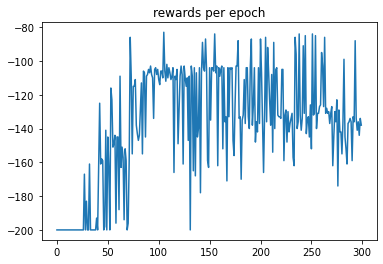

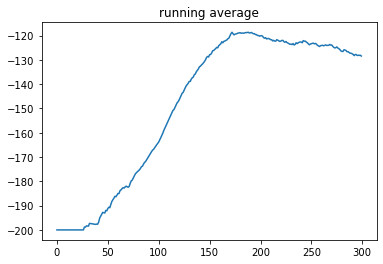

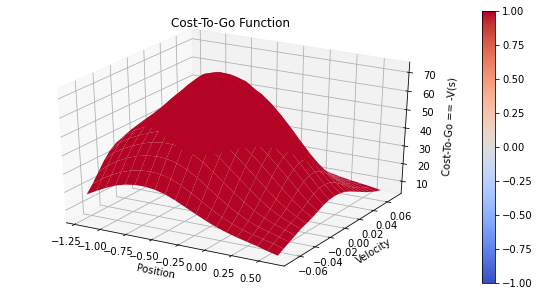

In [65]:
model.train()

In [66]:
model.test()

Average test reward:  -123.92


In [67]:
# see agent playing an episode
model.play_episode(training=False,render=True)

-149.0

<h1>Math</h1>

In this section we were going to summarize what we learned in this notebook

---

<h3>TD$(\lambda)$ Summary</h3>

In this section we learned reinforcement learning techniques that can be applied to any situation where we would use regular Q-learning or SARSA

And so while the examples we did were very specific, we should remember that they are more like general tools that we can test in a variety of situations

Although it may not have seemed like it we technically got some more practice with our RBF networks as well since that was the underlying feature expansion we use for this script

It is convenient that these kinds of details can be abstracted away so that we can focus only on the new parts

---

<h3>N-step Methods</h3>

First we looked at $n$-step method as a generalization of $\text{TD}(0)$ 

$\text{TD}(0)$ is a One-Step step return because it uses one sampled reward

But we saw that we can use any number of rewards in our calculation of the return in particular using $n$ rewards gives us the $n$-step return

If we take $n$ all the way to the end of the episode we are doing Monte-Carlo

---

Next we saw that we could combine all the $n$-step returns up to infinity and this gives us the $\lambda$ return

This is for the situation where we weigh each $n$-step return by geometrically decreasing $\lambda$

We saw that by manipulating our expression for the $\lambda$-return that $\lambda$ equals zero corresponds to $\text{TD}(0)$ and $\lambda$ equals 1 which we call $\text{TD}(1)$ corresponds to Monte-Carlo

---

<h3>Eligibility Traces</h3>

We then looked at an online algorithm using eligibility traces that approximates online $\text{TD}(\lambda)$

It is interestingly reassuring that the $\text{TD}(\lambda)$ algorithm looks a lot like the momentum update from deep learning

Think of these as new tools for our toolbox like all the other algorithms we learn in this series

It's not guaranteed that any particular algorithm will work for our problem but the more tools we have the more things we can try and the more likely it is that we'll come across a solution